In [1]:
import torch

GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length": 1024,
    "embd_dim": 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}


In [2]:
import tiktoken 
import torch
import torch.nn as nn
tokenizer = tiktoken.get_encoding("gpt2")
text = "Every effort moves you"
text1 = "Every days hold a "
batch = []
batch.append(torch.tensor(tokenizer.encode(text)))
batch.append(torch.tensor(tokenizer.encode(text1)))

In [3]:
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1528, 1745,  257,  220])]


In [4]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
         return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [5]:
import matplotlib.pyplot as plt     

NameError: name 'gca' is not defined

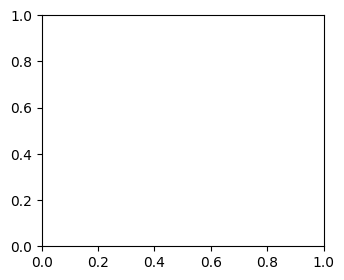

In [6]:
# Input tensor
x = torch.linspace(-3, 3, 100)
gelu, relu = GELU(), nn.ReLU()
# Compute activations
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)  # Create subplot
    plt.plot(x,y)  # Plot x vs. q   
    plt.title(f"{label} Activation Function")  # Add title
    plt.xlabel("x")  # Label for x-axis
    plt.ylabel(f"{label}(x)")  # Label for y-axis
    plt.grid(True)  # Add grid

# Adjust layout and display
plt.tight_layout()
plt.show()
nn.GELU

In [3]:
#Tokenization 
with open("verdict.txt",'r') as file:
    file = file.read()

print("Total no of characters", len (file))
file[:100]
#our goal is to tokenize 20479 characters 

Total no of characters 20479


'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g'

In [5]:
import re 
text = "Hello, How are you? My name is Ripesh Ghimire? Are you doinge well? Lets talk shall we "
result = re.split(r'(\s)',text)

In [7]:
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', file)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4649


In [25]:
#Now we convert the token into token id 
all_words = sorted(list(set(preprocessed)))
all_words.extend(["<|unk|>","<|endoftext|>"])
vocab_size = len(all_words)
print(vocab_size)

1161


In [31]:
#converting the given tokens into token-ids
vocab = {token:integer for integer,token in enumerate(all_words)}
ast_items = list(vocab.items())[-5:]

In [19]:
class SimpleTokenizer:
    def __init__(self,vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self,text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids 
    def decode(self,ids):
        text = "".join([self.int_to_str[i]for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #E
        return text

In [21]:
tokenizer = SimpleTokenizer(vocab)

In [38]:
#adding special context tokens 
'''
as we can see we applied simple tokenizer ti a passage from a training set In this section we will modify this tokenizer to handle unknown words
usage and addition of special context tokens that can enhance a model's understanding of context or other relevant information in the text. 
Thes special tokens can include markers for unknown words and document boundaries 

we will modify the vocabulary and toknizer we implemeneted in the previous section, Simple TokenizerV2 to support new token <|unk|> and <|end of text |>

why do you we add this tokens? 
so we add these tokens so we can know the new words that were not part of the training adata and thus not part of the existing vocabulary.  we add end of text token to know that we can user to separate two unrelated text sources

'''
class SimpleTokenizerV2:
    def __init__(self,vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self,text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids 
    def decode(self,ids):
        text = "".join([self.int_to_str[i]for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #E
        return text

In [7]:
text1 = "Hello do you like tea?"
text2 = "In the sunlit terraces ot the palace "
text = "<|endoftext|>".join((text1,text2))
print(text)

Hello do you like tea?<|endoftext|>In the sunlit terraces ot the palace 


In [8]:
tokenizer1 = SimpleTokenizerV2(vocab)
tokenizer1.encode(text)

NameError: name 'SimpleTokenizerV2' is not defined

In [9]:
tokenizer1.decode(tokenizer.encode(text))

NameError: name 'tokenizer1' is not defined

In [2]:
#Byte Pair Encoding 
'''
IT BUILDS IT vocabulary by iteratively mergin frequent characters into subwords and frequent subwords into words.
For example: BPE start with adding all individual single characters to its vocabulary ("a","b") IN the next stage, it merges characters combinations that frequently occur together with subwords. For
example d and e may be merge into the word "de" which is common in many English words like "define" "depend" "made" and "hiddden ". The merges are determined by frequency cut off 
'''

import tiktoken
encoder = tiktoken.encoding_for_model("gpt-2")

In [10]:
encoder.encode("HO00000867678678678678678w are you ")

[32298, 20483, 23, 3134, 30924, 30924, 30924, 30924, 30924, 86, 389, 345, 220]

In [11]:
encoder.decode(encoder.encode("How are you"))

'How are you'

'''
DATA SAMPLING WITH A SLIDING WINDOW 

'''

In [10]:
import tiktoken 
with open("verdict.txt",'r',encoding="utf-8") as f:
    text = f.read() 

In [12]:
tokenizer = tiktoken.get_encoding("gpt2")
enc_text = tokenizer.encode(text)

In [16]:
len(enc_text)

5145

In [17]:
enc_sample = enc_text[50:]

In [19]:
context_size = 4

In [23]:
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

In [24]:
x

[290, 4920, 2241, 287]

In [25]:
y

[4920, 2241, 287, 257]

In [26]:
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired  = enc_sample[i]
    print(context,"---------->",desired)

[290] ----------> 4920
[290, 4920] ----------> 2241
[290, 4920, 2241] ----------> 287
[290, 4920, 2241, 287] ----------> 257
